In [1]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from sklearn.model_selection import train_test_split
import sys
sys.path.append('..')
from utils.helpers import AggregateScalar, accuracy, set_torch_seeds

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
plt.style.use('ggplot')

# Make Dataset

In [2]:
seed = 4
set_torch_seeds(seed)

In [3]:
def make_hole(x, x1_0, x2_0, r):
    assert (len(x.shape)==2) and (x.shape[1] == 2)
    mask = (x[:,0] - x1_0)**2 + (x[:,1] - x2_0)**2 >= r**2
    return x[mask]

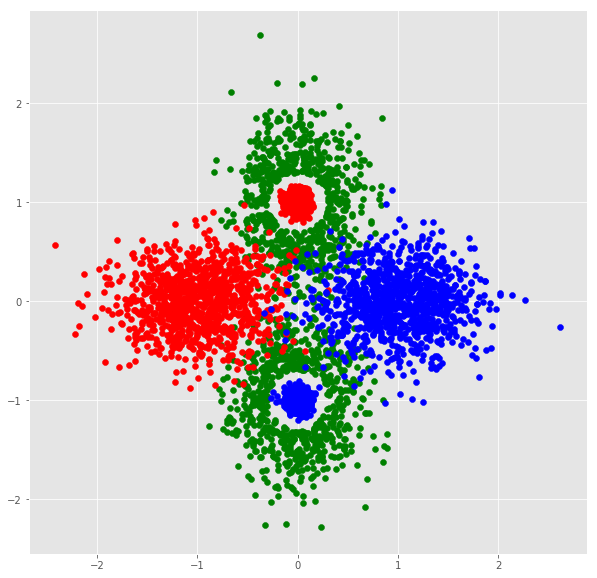

In [4]:
N = 1000
short, long, r_hole = 0.3, 0.4, 0.3
class1a = np.random.normal(loc=(0,1), scale=(short, long), size=(N, 2)) # scale=(x, y) = (width,height)
class1b = np.random.normal(loc=(0,-1), scale=(short, long), size=(N, 2))
class1a = make_hole(class1a, 0, 1, r_hole)
class1b = make_hole(class1b, 0, -1, r_hole)

class2a = np.random.normal(loc=(-1,0), scale=(long, short), size=(N, 2))
class2b = np.random.normal(loc=(0, 1), scale=(r_hole/5, r_hole/5), size=(int(N), 2))

class3a = np.random.normal(loc=(1, 0), scale=(long, short), size=(N, 2))
class3b = np.random.normal(loc=(0,-1), scale=(r_hole/5, r_hole/5), size=(int(N), 2))

X = np.vstack([class1a, class1b, class2a, class2b, class3a, class3b])
Y = np.hstack([np.zeros(len(class1a)), np.zeros(len(class1b)), np.ones(len(class2a)), np.ones(len(class2b)),  np.ones(len(class3a))*2,  np.ones(len(class3b))*2])

fig = plt.figure(figsize=(10,10))
plt.scatter(class1a[:,0], class1a[:,1], color='green')
plt.scatter(class1b[:,0], class1b[:,1], color='green')
plt.scatter(class2a[:,0], class2a[:,1], color='red')
plt.scatter(class2b[:,0], class2b[:,1], color='red')
plt.scatter(class3a[:,0], class3a[:,1], color='blue')
plt.scatter(class3b[:,0], class3b[:,1], color='blue')

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train, X_test, Y_train, Y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(Y_train), torch.from_numpy(Y_test)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, drop_last=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, drop_last=False, num_workers=1)

# Train teacher

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 3))         
    def forward(self, x):
        return self.layers(x)
    

In [7]:
teacher = MLP()
optimizer = optim.Adam(teacher.parameters(), lr=1e-3, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

for epoch in range(30):
    
    ## Train
    teacher.train()
    train_running_acc, train_running_loss = AggregateScalar(), AggregateScalar()
    for x,y in train_loader:
        x, y = x.float(), y.long()
        logits = teacher(x)
        loss = criterion(logits, y)
        acc = accuracy(logits.data, y, topk=(1,))[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_running_loss.update(float(loss), x.shape[0])
        train_running_acc.update(float(acc), x.shape[0])
        
    
    ## Test
    teacher.eval()
    test_running_acc, test_running_loss = AggregateScalar(), AggregateScalar()
    with torch.no_grad():
        for x,y in test_loader:
            x, y = x.float(), y.long()
            logits = teacher(x)
            loss = criterion(logits, y)
            acc = accuracy(logits.data, y, topk=(1,))[0]
            test_running_loss.update(float(loss), x.shape[0])
            test_running_acc.update(float(acc), x.shape[0])
        
    print('Epoch {} --- Train Loss: {:02.2f} -- Train Acc: {:02.2f}% -- Test Loss: {:02.2f} -- Test Acc: {:02.2f}%'.format(epoch, train_running_loss.avg(), train_running_acc.avg()*100, test_running_loss.avg(), test_running_acc.avg()*100))

Epoch 0 --- Train Loss: 0.54 -- Train Acc: 80.32% -- Test Loss: 0.39 -- Test Acc: 85.44%
Epoch 1 --- Train Loss: 0.31 -- Train Acc: 89.41% -- Test Loss: 0.27 -- Test Acc: 90.60%
Epoch 2 --- Train Loss: 0.22 -- Train Acc: 92.54% -- Test Loss: 0.21 -- Test Acc: 91.91%
Epoch 3 --- Train Loss: 0.18 -- Train Acc: 93.27% -- Test Loss: 0.17 -- Test Acc: 93.22%
Epoch 4 --- Train Loss: 0.16 -- Train Acc: 94.19% -- Test Loss: 0.16 -- Test Acc: 92.97%
Epoch 5 --- Train Loss: 0.14 -- Train Acc: 94.81% -- Test Loss: 0.14 -- Test Acc: 95.02%
Epoch 6 --- Train Loss: 0.13 -- Train Acc: 95.35% -- Test Loss: 0.14 -- Test Acc: 95.27%
Epoch 7 --- Train Loss: 0.13 -- Train Acc: 95.38% -- Test Loss: 0.14 -- Test Acc: 95.15%
Epoch 8 --- Train Loss: 0.12 -- Train Acc: 95.97% -- Test Loss: 0.13 -- Test Acc: 95.52%
Epoch 9 --- Train Loss: 0.11 -- Train Acc: 95.97% -- Test Loss: 0.12 -- Test Acc: 95.77%
Epoch 10 --- Train Loss: 0.11 -- Train Acc: 96.22% -- Test Loss: 0.13 -- Test Acc: 95.40%
Epoch 11 --- Train L

# Plotting Decision Boundaries

In [10]:
step = .02
T = 1 #softmax temperature
x1_min, x1_max = -3, 3 
x2_min, x2_max = -3, 3
x1_range, x2_range = np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step)
xx1, xx2 = np.meshgrid(x1_range, x2_range) # # (500, 400) for both, i.e (x2,x1) as (height,width) as wanted
xx1e, xx2e = np.expand_dims(xx1, -1), np.expand_dims(xx2, -1) # (500, 400, 1) for both
xx = np.concatenate([xx1e, xx2e], axis=-1) ## (500, 400, 2)

xxflat = xx.reshape((-1, 2)) #(200000, 2)
Y_teacher = torch.softmax(teacher(torch.from_numpy(xxflat).float())/T, dim=1).detach().numpy() #(200000, 3)
image_teacher = Y_teacher.reshape(x2_range.shape[0], x1_range.shape[0], 3) #(500, 400, 3)


In [11]:
def summary_fig(net='teacher', student=None, X_pseudo=None, save_path=None, mode='show', dpi=400):
    
    if mode=='save':
        %matplotlib agg
        %matplotlib agg
        
    #fig = plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(class1a[:,0], class1a[:,1], color='red', alpha=0.5, marker='s', zorder=0)
    ax.scatter(class1b[:,0], class1b[:,1], color='red', alpha=0.5, marker='s', zorder=0)
    ax.scatter(class2a[:,0], class2a[:,1], color='green', alpha=0.5, marker='o', zorder=5)
    ax.scatter(class2b[:,0], class2b[:,1], color='green', alpha=0.5, marker='o', zorder=5)
    ax.scatter(class3a[:,0], class3a[:,1], color='blue', alpha=0.5, marker='^', zorder=10)
    ax.scatter(class3b[:,0], class3b[:,1], color='blue', alpha=0.5, marker='^', zorder=10)
    if net=='teacher':
        ax.imshow(image_teacher, extent=[x1_min, x1_max, x2_min, x2_max], alpha=0.25, origin='lower') #by default, origin='upper' has y axis point down
    elif net =='student':
        assert student is not None
        Y_student = torch.softmax(student(torch.from_numpy(xxflat).float())/T, dim=1).detach().numpy() #(200000, 3)
        image_student = Y_student.reshape(x2_range.shape[0], x1_range.shape[0], 3) #(500, 400, 3)
        ax.imshow(image_student, extent=[x1_min, x1_max, x2_min, x2_max], alpha=0.25, origin='lower')
        
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_ticks_position('none') 
    
    if X_pseudo is not None:
        X_pseudo_np = X_pseudo.detach().numpy()
        plt.scatter(X_pseudo_np[:,0], X_pseudo_np[:,1], marker='P', s=150, linewidth='3', facecolor='yellow', edgecolor='black')
    
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    
    if mode=='save': 
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=dpi)
        %matplotlib inline
        %matplotlib inline

        
        
def double_summary_fig(student=None, X_pseudo=None, save_path=None, mode='show', dpi=400):
    """
    In order to make a single gif for git README
    """
    assert student is not None
    
    if mode=='save':
        %matplotlib agg
        %matplotlib agg
        
    fig = plt.figure(figsize=(22,10))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ## Teacher
    ax1.scatter(class1a[:,0], class1a[:,1], color='red', alpha=0.5, marker='s', zorder=0)
    ax1.scatter(class1b[:,0], class1b[:,1], color='red', alpha=0.5, marker='s', zorder=0)
    ax1.scatter(class2a[:,0], class2a[:,1], color='green', alpha=0.5, marker='o', zorder=5)
    ax1.scatter(class2b[:,0], class2b[:,1], color='green', alpha=0.5, marker='o', zorder=5)
    ax1.scatter(class3a[:,0], class3a[:,1], color='blue', alpha=0.5, marker='^', zorder=10)
    ax1.scatter(class3b[:,0], class3b[:,1], color='blue', alpha=0.5, marker='^', zorder=10)
    ax1.imshow(image_teacher, extent=[x1_min, x1_max, x2_min, x2_max], alpha=0.25, origin='lower')
    ax1.set_xlim(-3, 3)
    ax1.set_ylim(-3, 3)
    ax1.xaxis.set_major_formatter(NullFormatter())
    ax1.xaxis.set_ticks_position('none')
    ax1.yaxis.set_major_formatter(NullFormatter())
    ax1.yaxis.set_ticks_position('none')
    ax1.set_title(r'Teacher', size=40, y=1.06)
    
    ## Student
    Y_student = torch.softmax(student(torch.from_numpy(xxflat).float())/T, dim=1).detach().numpy() #(200000, 3)
    image_student = Y_student.reshape(x2_range.shape[0], x1_range.shape[0], 3) #(500, 400, 3)
    ax2.imshow(image_student, extent=[x1_min, x1_max, x2_min, x2_max], alpha=0.25, origin='lower')
    ax2.set_xlim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax2.xaxis.set_major_formatter(NullFormatter())
    ax2.xaxis.set_ticks_position('none')
    ax2.yaxis.set_major_formatter(NullFormatter())
    ax2.yaxis.set_ticks_position('none')
    ax2.set_title(r'Student', size=40, y=1.06)
    
    if X_pseudo is not None:
        X_pseudo_np = X_pseudo.detach().numpy()
        ax1.scatter(X_pseudo_np[:,0], X_pseudo_np[:,1], marker='P', s=200, linewidth='2', facecolor='yellow', edgecolor='black')
        ax2.scatter(X_pseudo_np[:,0], X_pseudo_np[:,1], marker='P', s=200, linewidth='2', facecolor='yellow', edgecolor='black')
    
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    
    if mode=='save': 
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=dpi)
        %matplotlib inline
        %matplotlib inline        


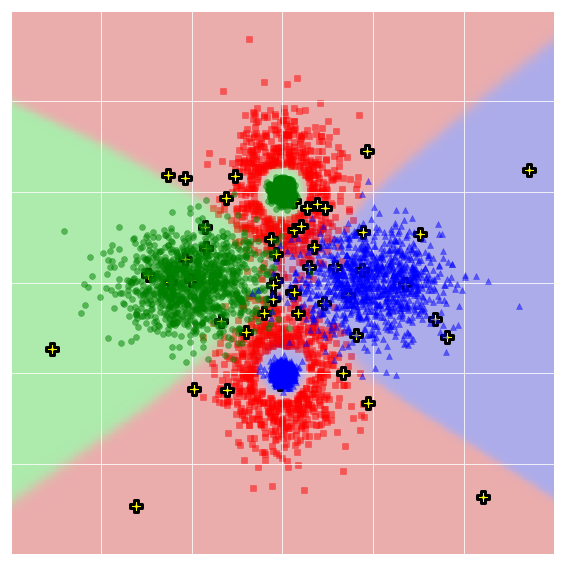

In [12]:
std_normal = torch.randn((50,2), dtype=torch.float, requires_grad=False)
X_pseudo_test = 1*std_normal + torch.FloatTensor([0,0])       
summary_fig(net='teacher', X_pseudo=X_pseudo_test, mode='show')

# Adversarial Belief Matching

In [13]:
pics_path = '../pics/'
if not os.path.exists(pics_path):
    os.makedirs(pics_path)
n_epochs = 2000
save_freq = 200
get_acc_freq = 1000
n_pseudo_iters = 50
n_student_iters = 10
fig_dpi = 400

In [14]:
np.random.seed(seed)
set_torch_seeds(seed)
teacher.eval()
student = MLP()
student.train()

## Normally distributed
std_normal = torch.randn((50,2), dtype=torch.float, requires_grad=False)
X_pseudo = 1*std_normal + torch.FloatTensor([3,3])
X_pseudo.requires_grad = True

optimizer_student = optim.Adam(student.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizer_pseudo = optim.Adam([X_pseudo], lr=1e-3, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    
    print('Epoch {}'.format(epoch))
    
    ## Train pseudo points
    for i in range(n_pseudo_iters):
        X_pseudo_norm = 6*torch.sigmoid(X_pseudo) - 3 # [-3,3]
        student_logits = student(X_pseudo_norm)
        teacher_logits = teacher(X_pseudo_norm)
        student_loss = F.kl_div(F.log_softmax(student_logits, dim=1), F.softmax(teacher_logits, dim=1))
        pseudo_loss = -student_loss

        optimizer_pseudo.zero_grad()
        pseudo_loss.backward()
        X_pseudo.grad.data.clamp_(-3,3)
        optimizer_pseudo.step()
    
    ## Train student
    for i in range(n_student_iters):
        X_pseudo_norm = 6*torch.sigmoid(X_pseudo) - 3 # [-3,3]
        student_logits = student(X_pseudo_norm)
        teacher_logits = teacher(X_pseudo_norm)
        student_loss = F.kl_div(F.log_softmax(student_logits, dim=1), F.softmax(teacher_logits, dim=1))
            
        optimizer_student.zero_grad()
        student_loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 3)
        optimizer_student.step()
    
    
    ## Save figs
    if epoch % save_freq == 0:
        print('Saving figure...')
        double_summary_fig(student=student, X_pseudo=X_pseudo_norm, save_path=pics_path+'image{:06d}.png'.format(epoch), mode='save', dpi=fig_dpi)

    
    if epoch % get_acc_freq == 0:
        print('Getting accuracy...')
        student.eval()   
        train_running_acc, train_running_loss = AggregateScalar(), AggregateScalar()
        with torch.no_grad():
            for x,y in train_loader:
                x, y = x.float(), y.long()
                logits = student(x) #(50,1)
                loss = criterion(logits, y)
                acc = accuracy(logits.data, y, topk=(1,))[0]
                train_running_loss.update(float(loss), x.shape[0])
                train_running_acc.update(float(acc), x.shape[0])
        student.train()
        print('Epoch {} --- Train Loss: {:02.2f} -- Train Acc: {:02.2f}% -- Student-Teacher KL div: {:02.2f}'.format(epoch, train_running_loss.avg(), train_running_acc.avg()*100, student_loss))
        
    
## Accuracy on real train data
student.eval()
test_running_acc, test_running_loss = AggregateScalar(), AggregateScalar()
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.float(), y.long()
        logits = student(x)
        loss = criterion(logits, y)
        acc = accuracy(logits.data, y, topk=(1,))[0]
        test_running_loss.update(float(loss), x.shape[0])
        test_running_acc.update(float(acc), x.shape[0])

    print('\n Test Loss: {:02.2f} -- Test Acc: {:02.2f}%'.format(test_running_loss.avg(), test_running_acc.avg()*100))

Epoch 0


c:\users\paulm\miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Saving figure...
Getting accuracy...
Epoch 0 --- Train Loss: 1.20 -- Train Acc: 47.03% -- Student-Teacher KL div: 0.10
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31


KeyboardInterrupt: 